# Predict Next Purchase Day Range of the Customers

### Libraries Import & data import

Import the following libraries in the notebook
1. Pandas
2. Numpy (Numerical Python)
3. matplotlib
4. sklearn and pretrained models from sklearn
5. warnings (to suppress warning messages regarding deprecation)

Also import the dataset in the notebook using pandas.read_csv() function. Also, set the encoding to windows-1252

In [243]:
# import libraries

import pandas as pd # pandas library 
import numpy as np # numerical python library
import matplotlib.pyplot as plt # plotting library


import sklearn as sk
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score

from datetime import datetime, timedelta, date

from __future__ import division # use / to perform floor division

# show charts and graphs inline in jupyter notebook
%matplotlib inline 

In [126]:
# here we import algorithms

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [127]:
#supress all the warnings of deprecation

import warnings
warnings.filterwarnings("ignore")

In [128]:
#read data
raw_data = pd.read_csv('OnlineRetail.csv', encoding='Windows-1252') 

In [129]:
raw_data.shape

(541909, 8)

In [130]:
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Data Wrangling

#### Steps:
1. Convert dates fields to dates using .to_datetime().dt.date
2. Get data for a particular country using conditional selection
3. Separate the data for 6 months and next 3 months
4. Get the list of users in the first 6 months for which next purchase date will be predicted
5. Get last purchase day of each customer in first 6 months and get first purchase date in next 3 months. hence create the dataframe containing each user from first 6 month, it's last purchase date and next purchase date
6. Get the dates difference in separate column and merge it with the users list we had. Also, fill the na values using fillna() function


In [131]:
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate']).dt.date

In [132]:
raw_data['InvoiceDate'].describe()

count         541909
unique           305
top       2011-12-05
freq            5331
Name: InvoiceDate, dtype: object

In [133]:
tx_uk = raw_data.loc[raw_data.Country=='United Kingdom'].reset_index(drop=True)

In [134]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [135]:
# separate 6 month data 1-3-11 to 1-9-11 and next 3 months data
tx_6m = tx_uk[(tx_uk.InvoiceDate < date(2011,9,1)) & (tx_uk.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)
tx_next = tx_uk[(tx_uk.InvoiceDate >= date(2011,9,1)) & (tx_uk.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

In [136]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01,7.95,14620.0,United Kingdom
1,545220,48194,DOORMAT HEARTS,2,2011-03-01,7.95,14620.0,United Kingdom
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01,1.65,14620.0,United Kingdom
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01,4.95,14620.0,United Kingdom
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01,3.75,14620.0,United Kingdom


In [137]:
tx_next.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565080,20677,PINK POLKADOT BOWL,8,2011-09-01,1.25,13509.0,United Kingdom
1,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01,1.25,13509.0,United Kingdom
2,565081,21067,NaN,1,2011-09-01,0.00,NaN,United Kingdom
3,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01,12.75,13305.0,United Kingdom
4,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01,3.75,13305.0,United Kingdom


In [138]:
tx_next['InvoiceDate'].describe()

count         178694
unique            78
top       2011-11-29
freq            4166
Name: InvoiceDate, dtype: object

In [139]:
# get customers list to finally predict the next purchase date
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [140]:
tx_user.head()

,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


In [141]:
tx_user.count()

CustomerID    2568
dtype: int64

In [142]:
# get first purchase date in next 3 months data for each customer
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

In [143]:
tx_next_first_purchase.head()

,CustomerID,MinPurchaseDate
0,12747.0,2011-10-04
1,12748.0,2011-09-02
2,12749.0,2011-11-17
3,12820.0,2011-09-26
4,12822.0,2011-09-13


In [144]:
tx_next_first_purchase.count()

CustomerID         2597
MinPurchaseDate    2597
dtype: int64

In [145]:
# get last purchase date of each customer in the 6 months data
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [146]:
# merge the two dates to get last purchase date and next purchase date of each customer of first 6 month
tx_purchase_dates = pd.merge(tx_last_purchase, tx_next_first_purchase, on='CustomerID', how='left')
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

In [147]:
tx_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12747.0,2011-08-22,2011-10-04,43.0
1,12748.0,2011-08-30,2011-09-02,3.0
2,12749.0,2011-08-18,2011-11-17,91.0
3,12821.0,2011-05-09,NaN,NaN
4,12823.0,2011-08-04,2011-09-26,53.0


In [148]:
tx_purchase_dates['CustomerID'].count()

2568

In [149]:
# merge with the individual users list
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [150]:
tx_user.head()

,CustomerID,NextPurchaseDay
0,14620.0,NaN
1,14740.0,NaN
2,13880.0,58.0
3,16462.0,112.0
4,17068.0,16.0


In [151]:
tx_user.shape

(2569, 2)

In [152]:
tx_user = tx_user.fillna(999)

In [153]:
tx_user.count()

CustomerID         2569
NextPurchaseDay    2569
dtype: int64

### Features Engineering

We will find the RFM value for each customer. RFM = Recency Frequency Monetary Value <br>
    Recency ==> When did the customer purchased any item recently?<br>
    Frequency ==> How many times did the customer purchased any item?<br>
    Monetary Value ==> When did the customer purchased any item recently?<br>
    
Features to be considered for predicting the next purchase date :
1. RFM value & clustering (to classify customers according to their value for the store)
2. Days between last three purchases (for recent pattern/trend)
3. Mean & S.D. of the difference between purchases in days (for overall pattern/trend)

#### RFM Value & clustering (using K-means)


###### Recency

In [154]:
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [155]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [156]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [157]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [158]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency
0,14620.0,999.0,104
1,14740.0,999.0,91
2,13880.0,58.0,45
3,16462.0,112.0,85
4,17068.0,16.0,10


In [159]:
tx_user.Recency.describe()

count    2568.000000
mean       66.751168
std        52.254904
min         0.000000
25%        20.750000
50%        55.000000
75%       104.000000
max       183.000000
Name: Recency, dtype: float64

Text(0, 0.5, 'No. of customers')

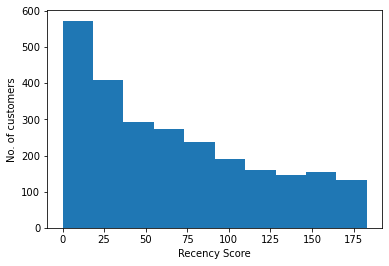

In [160]:
plt.hist(tx_user.Recency)
plt.xlabel("Recency Score")
plt.ylabel("No. of customers")

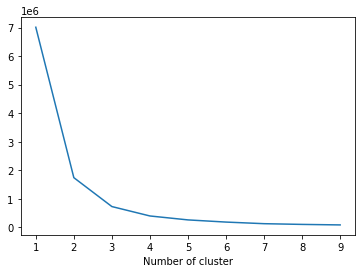

In [161]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [162]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [163]:
tx_user.RecencyCluster

0       0
1       0
2       1
3       0
4       3
       ..
2563    3
2564    3
2565    3
2566    3
2567    3
Name: RecencyCluster, Length: 2568, dtype: int32

In [164]:
# make the cluster numbers as per order
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     print(df_new)
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     print(df_new)
    df_new['index'] = df_new.index
#     print(df_new)
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [165]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [166]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,443.0,155.083521,15.613249,127.0,141.0,154.0,167.0,183.0
1,579.0,97.452504,14.213610,75.0,85.0,98.0,110.5,126.0
2,665.0,50.972932,12.405881,33.0,40.0,49.0,62.0,73.0
3,881.0,14.066969,8.886344,0.0,7.0,13.0,21.0,31.0


###### Frequency

In [167]:
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [168]:
tx_frequency.columns = ['CustomerID','Frequency']

In [169]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,50
1,12748.0,1210
2,12749.0,160
3,12821.0,6
4,12823.0,2


In [170]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [171]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,14620.0,999.0,104,1,30
1,14740.0,999.0,91,1,93
2,16462.0,112.0,85,1,2
3,15676.0,178.0,113,1,63
4,15092.0,999.0,115,1,26


In [172]:
tx_user.Frequency.describe()

count    2568.000000
mean       55.985981
std       109.245890
min         1.000000
25%        13.000000
50%        29.000000
75%        64.000000
max      3546.000000
Name: Frequency, dtype: float64

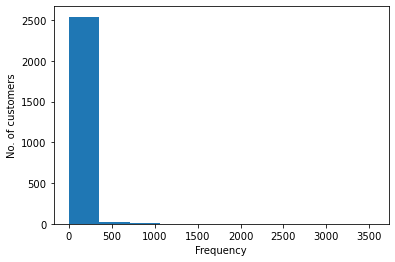

In [173]:
plt.hist(tx_user.Frequency)
plt.xlabel("Frequency")
plt.ylabel("No. of customers")
plt.show()

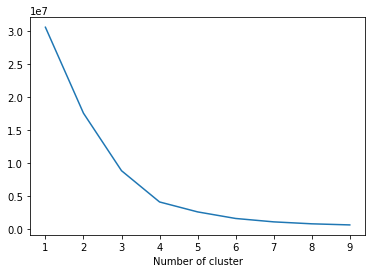

In [174]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [175]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [176]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0
1,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
2,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0
3,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0


In [177]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

###### Monetary Value

In [178]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [179]:
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

In [180]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1760.09
1,12748.0,8115.68
2,12749.0,2532.55
3,12821.0,92.72
4,12823.0,688.50


In [181]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [182]:
tx_user.Revenue.describe()

count     2568.000000
mean      1078.621843
std       3156.461431
min      -4287.630000
25%        222.967500
50%        440.130000
75%       1026.340000
max      88948.330000
Name: Revenue, dtype: float64

In [183]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,14620.0,999.0,104,1,30,0,393.28
1,14740.0,999.0,91,1,93,0,1423.21
2,16462.0,112.0,85,1,2,0,68.00
3,15676.0,178.0,113,1,63,0,877.40
4,15092.0,999.0,115,1,26,0,457.81


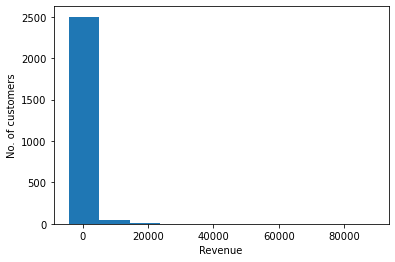

In [184]:
plt.hist(tx_user.Revenue)
plt.xlabel("Revenue")
plt.ylabel("No. of customers")
plt.show()

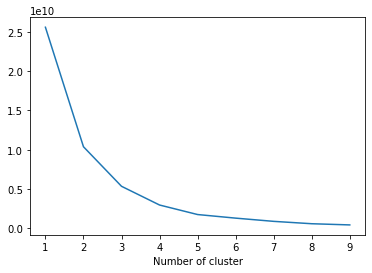

In [185]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [186]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
len(tx_user)

2568

In [187]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [188]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


###### Overall RFM Score Calculation

In [189]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,999.0,104,1,30,0,393.28,0
1,14740.0,999.0,91,1,93,0,1423.21,0
2,16462.0,112.0,85,1,2,0,68.00,0
3,15676.0,178.0,113,1,63,0,877.40,0
4,15092.0,999.0,115,1,26,0,457.81,0


In [190]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [191]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,155.173516,19.392694,285.837511
1,98.292335,27.224599,446.093084
2,52.694719,37.529703,576.943186
3,18.465492,52.588840,904.059517
4,15.483696,160.429348,2526.410000
5,9.828947,214.855263,6653.958947
6,8.812500,568.562500,13181.453125
7,12.200000,591.600000,46209.390000
8,3.000000,3546.000000,16643.220000


In [192]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    438
1    561
2    606
3    681
4    184
5     76
6     16
7      5
8      1
Name: Recency, dtype: int64

In [193]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [194]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,112.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value


#### Get last three purchase date difference and mean & S.D.

In [195]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01,7.95,14620.0,United Kingdom,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01,7.95,14620.0,United Kingdom,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01,1.65,14620.0,United Kingdom,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01,4.95,14620.0,United Kingdom,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01,3.75,14620.0,United Kingdom,15.00


In [196]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]

In [197]:
#Convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate']

In [198]:
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])

In [199]:
#Drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [200]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [201]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
649,12747.0,2011-03-01,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25,2011-05-25,2011-05-05,2011-03-01,NaN
124699,12747.0,2011-06-28,2011-06-28,2011-05-25,2011-05-05,2011-03-01
184410,12747.0,2011-08-22,2011-08-22,2011-06-28,2011-05-25,2011-05-05


In [202]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [203]:
tx_day_order.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
7326,12748.0,2011-03-08,2011-03-08,NaN,NaN,NaN,NaN,NaN,NaN
10606,12748.0,2011-03-11,2011-03-11,2011-03-08,NaN,NaN,3.0,NaN,NaN
17545,12748.0,2011-03-18,2011-03-18,2011-03-11,2011-03-08,NaN,7.0,10.0,NaN
20123,12748.0,2011-03-21,2011-03-21,2011-03-18,2011-03-11,2011-03-08,3.0,10.0,13.0
24764,12748.0,2011-03-24,2011-03-24,2011-03-21,2011-03-18,2011-03-11,3.0,6.0,13.0


In [204]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()



In [205]:
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [206]:
tx_day_diff.head()

,CustomerID,DayDiffMean,DayDiffStd
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834
3,12821.0,NaN,NaN
4,12823.0,127.000000,NaN


In [207]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [208]:
tx_day_order_last.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
184410,12747.0,2011-08-22,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
192527,12748.0,2011-08-30,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0
181411,12749.0,2011-08-18,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0
70339,12821.0,2011-05-09,2011-05-09,NaN,NaN,NaN,NaN,NaN,NaN
169417,12823.0,2011-08-04,2011-08-04,2011-03-30,NaN,NaN,127.0,NaN,NaN
122212,12826.0,2011-06-24,2011-06-24,2011-06-14,NaN,NaN,10.0,NaN,NaN
182629,12828.0,2011-08-19,2011-08-19,2011-08-01,NaN,NaN,18.0,NaN,NaN
162086,12830.0,2011-07-28,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0
21424,12831.0,2011-03-22,2011-03-22,NaN,NaN,NaN,NaN,NaN,NaN
147556,12833.0,2011-07-17,2011-07-17,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
tx_day_order_last = tx_day_order_last.dropna()

In [210]:
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')

In [211]:
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')


In [212]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
1,17770.0,999.0,98,1,38,0,1143.27,0,1,Low-Value,14.0,77.0,84.0,28.000000,30.512293
2,15643.0,999.0,79,1,36,0,647.40,0,1,Low-Value,5.0,6.0,12.0,25.750000,43.553607
3,14231.0,999.0,79,1,35,0,513.11,0,1,Low-Value,4.0,53.0,103.0,34.333333,26.274195
4,18218.0,999.0,106,1,24,0,626.38,0,1,Low-Value,5.0,61.0,75.0,25.000000,27.221315


In [213]:
len(tx_user)

623

In [ ]:
# PIYUSH GARG

In [214]:
tx_class = tx_user.copy()

In [215]:
tx_class = pd.get_dummies(tx_class)

In [216]:
tx_class.tail(10)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
613,16029.0,12.0,7,3,127,1,17081.82,2,6,6.0,7.0,19.0,7.318182,5.276961,1,0,0
614,17511.0,21.0,14,3,450,1,37661.72,2,6,9.0,13.0,28.0,9.625000,7.940403,1,0,0
615,14680.0,26.0,21,3,145,1,15847.56,2,6,14.0,33.0,57.0,19.142857,10.976165,1,0,0
616,14088.0,74.0,28,3,203,1,17886.66,2,6,7.0,15.0,21.0,12.400000,7.436397,1,0,0
617,15311.0,14.0,12,3,1061,2,31277.65,2,7,1.0,4.0,9.0,4.750000,3.417392,1,0,0
618,13089.0,1.0,0,3,895,2,22670.13,2,7,6.0,9.0,12.0,4.214286,3.008409,1,0,0
619,14298.0,24.0,23,3,750,2,23767.94,2,7,18.0,42.0,67.0,14.400000,10.297788,1,0,0
620,17841.0,4.0,3,3,3546,3,16643.22,2,8,3.0,5.0,9.0,3.423077,1.318736,1,0,0
621,18102.0,28.0,26,3,136,1,88948.33,3,7,8.0,16.0,32.0,12.916667,9.718383,1,0,0
622,17450.0,2.0,0,3,116,1,64382.90,3,7,8.0,14.0,34.0,11.666667,8.820971,1,0,0


### Model selection & Testing

next_purchase_day_value

0–20: Customers that will purchase in 0–20 days — Class name: 2

21–49: Customers that will purchase in 21–49 days — Class name: 1

≥ 50: Customers that will purchase in more than 50 days — Class name: 0

In [217]:
tx_user.NextPurchaseDay.describe()

count    623.000000
mean     176.815409
std      326.316847
min        1.000000
25%       25.000000
50%       48.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [218]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0


In [219]:
tx_class.NextPurchaseDayRange.value_counts()/len(tx_user)

0    0.478331
1    0.340289
2    0.181380
Name: NextPurchaseDayRange, dtype: float64

In [220]:
corr = tx_class[tx_class.columns].corr()
print(corr)

                      CustomerID  NextPurchaseDay   Recency  RecencyCluster  \
CustomerID              1.000000         0.016157 -0.037999        0.030507   
NextPurchaseDay         0.016157         1.000000  0.305883       -0.286579   
Recency                -0.037999         0.305883  1.000000       -0.919873   
RecencyCluster          0.030507        -0.286579 -0.919873        1.000000   
Frequency               0.007532        -0.156609 -0.176533        0.141191   
FrequencyCluster        0.000118        -0.233790 -0.227845        0.185922   
Revenue                 0.047073        -0.129973 -0.174385        0.151742   
RevenueCluster         -0.008947        -0.143801 -0.245947        0.205987   
OverallScore            0.012021        -0.319256 -0.688249        0.693040   
DayDiff                 0.015377         0.040574 -0.046505        0.064340   
DayDiff2               -0.001886         0.108178 -0.057685        0.071240   
DayDiff3               -0.019482         0.085301 -0

In [221]:
tx_class = tx_class.drop('NextPurchaseDay',axis=1)

In [222]:
len(tx_class)

623

In [223]:
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [224]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("GBC",GradientBoostingClassifier()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("MLP",MLPClassifier()))


In [225]:
for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.6184739  0.59437751]
NB [0.65461847 0.61445783]
RF [0.59036145 0.56626506]
SVC [0.51807229 0.5060241 ]
Dtree [0.562249   0.55421687]
GBC [0.56626506 0.58232932]
KNN [0.48995984 0.51405622]
MLP [0.23694779 0.52208835]


In [226]:
X_test.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
133,14560.0,9,3,19,0,744.28,0,3,25.0,53.0,87.0,24.857143,20.594729,0,0,1
286,14776.0,5,3,63,0,1291.38,0,3,39.0,66.0,70.0,25.600000,16.303374,0,0,1
153,15400.0,13,3,12,0,561.70,0,3,15.0,64.0,71.0,41.250000,39.601136,0,0,1
616,14088.0,28,3,203,1,17886.66,2,6,7.0,15.0,21.0,12.400000,7.436397,1,0,0
593,15640.0,21,3,205,1,4508.69,1,5,3.0,19.0,64.0,23.800000,18.267457,1,0,0


In [241]:
for name,model in models:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name.center(100,'-'))
    print()
    print(classification_report(y_test, y_pred))
    print("Accuracy = ", accuracy_score(y_pred, y_test))
    print("\n")

-------------------------------------------------LR-------------------------------------------------

              precision    recall  f1-score   support

           0       0.65      0.75      0.69        55
           1       0.58      0.56      0.57        52
           2       0.67      0.44      0.53        18

    accuracy                           0.62       125
   macro avg       0.63      0.58      0.60       125
weighted avg       0.62      0.62      0.62       125

Accuracy =  0.624


-------------------------------------------------NB-------------------------------------------------

              precision    recall  f1-score   support

           0       0.76      0.64      0.69        55
           1       0.57      0.58      0.57        52
           2       0.38      0.56      0.45        18

    accuracy                           0.60       125
   macro avg       0.57      0.59      0.57       125
weighted avg       0.63      0.60      0.61       125

Accuracy =  0.

##### Considering the accuracy, RandomForest Classifier is having most stable accuracy

In [242]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.608